# Create a boxplot of avoided fuel emissions distribution 

Attribute: 'emissions_avoided'

Filters:
* Sector = Food Manufacturing (NAICS code = 311*)
* Period = 2014 - 2024 (last 10 years)
* Implemented vs Not Implemented
* ARCs = TBD
* State = CA
    * Question: do we want to offer a comparative boxplots? or only aggregate?

### Notebook generates the following boxplot:

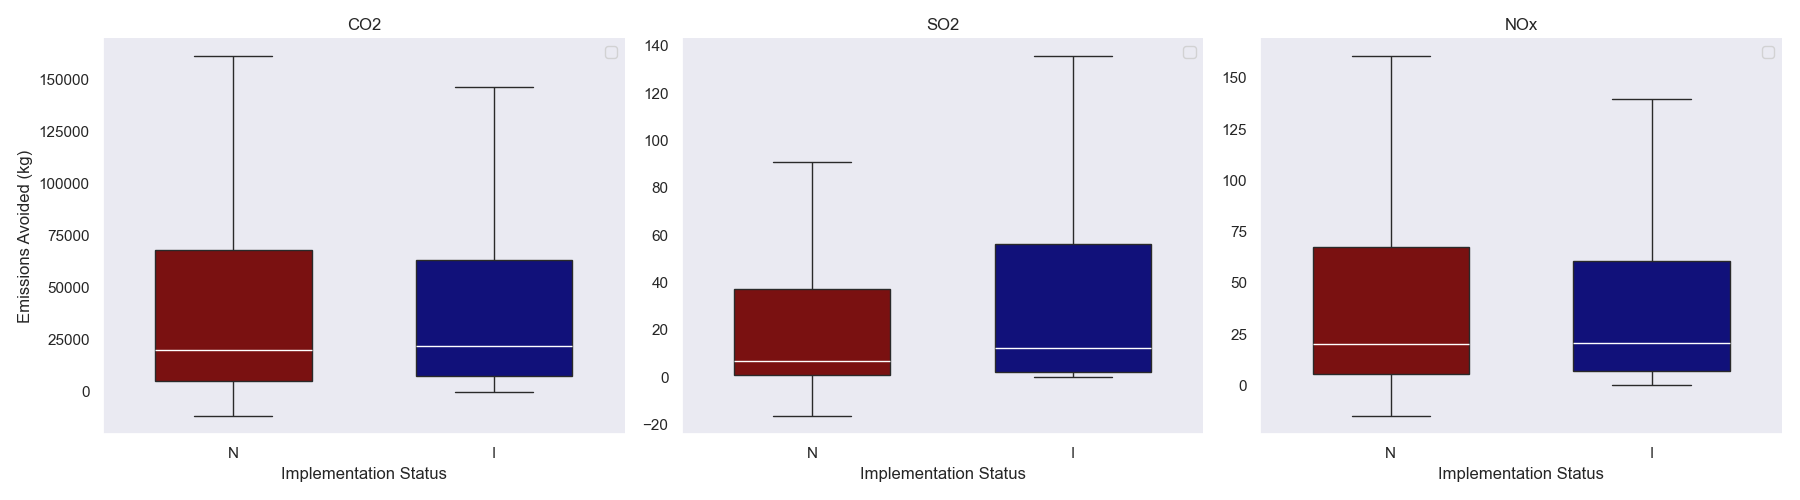

In [1]:
from IPython.display import Image

image_path = '../assets/emissions_avoided_facetgrid.png'

# Display the image
Image(image_path)

# Data Preparation

In [ ]:
# Import libraries
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import janitor
from janitor import clean_names

In [ ]:
# Import datasets

# ------- define paths -------
relative_path = Path('../data/intermediate_data/') # define relative path
absolute_path = relative_path.resolve() # get absolute path


# ------- import data -------
assess_df = pd.read_csv(absolute_path/'iac_assess_tidy.csv') # import IAC assess dataset
ec_emissions_df = pd.read_csv(absolute_path/'emissions_tidy.csv') # import emissions dataset
ec_generation_df = pd.read_csv(absolute_path/'generation.csv') # import electricity generation dataset
recc_integrated_ppi_df = pd.read_csv(absolute_path/'recc_integrated_ppi.csv') # import an integrated recc dataset with adjusted impcost
fuel_emission_factors_df = pd.read_excel(absolute_path/'emission_factors_tidy.xlsx', sheet_name='Sheet1') # import fuel emission factors

In [ ]:
ec_emissions_df

In [ ]:
fuel_emission_factors_df

In [ ]:
assess_df = assess_df.clean_names()

In [ ]:
recc_integrated_ppi_df = recc_integrated_ppi_df.dropna(subset=['sourccode', 'conserved','sourconsv','saved'], how='all')
recc_integrated_ppi_df[recc_integrated_ppi_df['superid']=='AM043901']

In [ ]:
# Add Sector and State attributes to recc_integrated_ppi_df from assess_df
integrated_ppi_df = pd.merge(recc_integrated_ppi_df, assess_df[['state','naics','id']],
                                  on='id',
                                  how='left')

integrated_ppi_df.drop_duplicates(inplace = True)

In [ ]:
# check unique power source codes 
integrated_ppi_df['sourccode'].unique()


In [ ]:
integrated_ppi_df[integrated_ppi_df['superid']=='WV061012']

#### Merge Fuel Emission Factors into the integrated recc table

In [ ]:
# add fuel emission factors to the integrated recc df
integrated_df = pd.merge(integrated_ppi_df, fuel_emission_factors_df[['sourccode','emission_type','emission_factor','emission_factor_units']],
                                  on='sourccode',
                                  how='left')

In [ ]:
integrated_df[integrated_df['superid'].isin(['WV061012', 'AM057403'])]

#### Calculate fuel emission factors

In [ ]:
# Calculate fuel emissions avoided
integrated_df['emissions_avoided'] = integrated_df['emission_factor'] * integrated_df['conserved']

In [ ]:
integrated_df[integrated_df['superid'].isin(['WV061012', 'AM057403'])]

# Merge electricity emissions into an integrated recc table

In [ ]:
ec_emissions_df = ec_emissions_df[(ec_emissions_df['producer_type']=='Total Electric Power Industry')& # units = metric ton
                                  (ec_emissions_df['energy_source']=='All Sources')]

ec_generation_df = ec_generation_df[(ec_generation_df['type_of_producer']=='Total Electric Power Industry')&
                                  (ec_generation_df['energy_source']=='Total')]

In [ ]:
ec_emissions_df

In [ ]:
# calculate emission factors
# Total Emissions/Total Electricity Generated
ec_emission_factors_df = pd.merge(ec_generation_df,ec_emissions_df[['year','state','emission_type','amount']])
ec_emission_factors_df['emission_factor'] = ec_emission_factors_df['amount'] / ec_emission_factors_df['generation_megawatthours_']

# add column emission_factor_units
ec_emission_factors_df['emission_factor_units'] = 'kg/kWh'
ec_emission_factors_df['sourccode'] = 'EC'

In [ ]:
ec_emission_factors_df

In [ ]:
integrated_df.columns

In [ ]:
integrated_df = pd.merge(integrated_df, ec_emission_factors_df[['state','year','emission_type','emission_factor','emission_factor_units','sourccode']],
                         left_on=['fy','state','sourccode'],
                         right_on=['year','state','sourccode'],
                         how='left')

# merge overlapping columns
integrated_df['emission_type'] = integrated_df['emission_type_x'].combine_first(integrated_df['emission_type_y'])
integrated_df['emission_factor_units'] = integrated_df['emission_factor_units_x'].combine_first(integrated_df['emission_factor_units_y'])
integrated_df['emission_factor'] = integrated_df['emission_factor_x'].combine_first(integrated_df['emission_factor_y'])

# drop the old duplicate columns
integrated_df.drop(columns=['emission_type_x', 'emission_type_y', 'emission_factor_units_x', 'emission_factor_units_y', 'year','emission_factor_x','emission_factor_y'], 
                   inplace=True)


In [ ]:
integrated_df[integrated_df['superid'].isin(['WV061012', 'AM057403'])]

In [ ]:
integrated_df.loc[integrated_df['sourccode'] == 'EC', 'emissions_avoided'] = (
    integrated_df['emission_factor'] * integrated_df['conserved']
)

In [ ]:
integrated_df[integrated_df['superid'].isin(['WV061012', 'AM057403'])]

### Set Filters

In [ ]:
# get arcs2 for sector = 311 (food production)
recc_integrated_ppi_311_df = integrated_ppi_df[integrated_ppi_df['naics'].astype(str).str.startswith('311')]
recc_integrated_ppi_311_df = integrated_ppi_df[integrated_ppi_df['arc2'].astype(str).str.startswith('2.')]

recc_integrated_ppi_311_df[recc_integrated_ppi_311_df['superid']=='AM043901']
recc_integrated_ppi_311_df[recc_integrated_ppi_311_df['id']=='AM0439']

recc_integrated_ppi_311_df['arc2'].unique()[:15]

In [ ]:
# set filters
arc2_filter = [2.8114, 2.7142, 2.7111, 2.7447, 2.7233, 2.6221, 2.7226, 2.6212,
       2.4111, 2.7133, 2.3212, 2.7224, 2.2437, 2.6218, 2.4236]
sector_filter = '311'
period_filter_from = 2010
period_filter_to = 2024

In [ ]:

filtered_df = integrated_df[
    (integrated_df['naics'].astype(str).str.startswith(sector_filter)) &
    (integrated_df['arc2'].isin(arc2_filter)) &
    (integrated_df['fy'] >= period_filter_from) &
    (integrated_df['fy'] <= period_filter_to) &
    (integrated_df['emission_type'].isin(['CO2','SO2','NOx']))
]

In [ ]:
filtered_df

In [ ]:
# test that filters values are correct
print("Unique values in arc2:", filtered_df['arc2'].unique())
print("Unique values in arc2:", filtered_df['fy'].unique())
print(len(filtered_df['arc2'].unique()))

filtered_df

Managing Outliers for Better Visualization 
Method: set showfliers=False in the sns.boxplot. This allows keeping all data in a dataframe while hiding the outliers on a chart.
Seaborn uses Interquartile Range (IQR) Rule to determine outliers:

Outlier Calculation Using IQR:

First Quartile (Q1) = 25th percentile
Third Quartile (Q3) = 75th percentile
Interquartile Range (IQR) = Q3 - Q1
Outliers are defined as any values:
Below: Q1 - 1.5 × IQR
Above: Q3 + 1.5 × IQR

In [ ]:
Q1 = filtered_df["emissions_avoided"].quantile(0.25)
Q3 = filtered_df["emissions_avoided"].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
Q1

In [ ]:
# calculate the outliers

# Compute Q1, Q3, and IQR
Q1 = filtered_df["emissions_avoided"].quantile(0.25)
Q3 = filtered_df["emissions_avoided"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = filtered_df[(filtered_df["emissions_avoided"] < lower_bound) | (filtered_df["emissions_avoided"] > upper_bound)]

# Display outliers
print(outliers[["impstatus", "emissions_avoided"]])

In [ ]:
# Define a path to save visualizations

# Define relative path
relative_path_vis = Path('../assets/')
absolute_path_vis = relative_path_vis.resolve() # get absolute path

In [ ]:
sns.set_theme(style="dark")

# Define color palette
palette = {"N": "darkred", "I": "darkblue"}

# Create FacetGrid for separate plots
g = sns.FacetGrid(filtered_df, col="emission_type", sharey=False, height=5, aspect=1.2)

# Map the boxplot to each facet
g.map_dataframe(sns.boxplot, x="impstatus", y="emissions_avoided", 
                width=0.6, palette=palette, 
                showfliers=False, 
                medianprops={'color': 'white', 'linewidth': 1},
                hue='impstatus',
                legend=False)

# Adjust titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Implementation Status", "Emissions Avoided (kg)")

# Customize legend
for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Not Implemented", "Implemented"])

# Save the plot
plt.savefig(absolute_path_vis / "emissions_avoided_facetgrid.png", format='png')

plt.show()


In [ ]:
# export data

integrated_df.to_csv("../data/intermediate_data/iac_integrated.csv", index=False)
filtered_df.to_csv("../data/intermediate_data/iac_integrated_mockup.csv", index=False)